In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import unicodedata
import re
import json
from tqdm.notebook import tqdm
from tqdm import tqdm
import pandas as pd



In [2]:
import os

CONFIG = {
    "dataset_path": r"D:\Project\data\LJSpeech-1.1",
    "output_path": r"D:\Project\data\LJSpeech-1.1\preprocessed",
    "sample_rate": 22050,
    "n_mels": 80,
    "hop_length": 256,
    "win_length": 1024,
    "min_audio_duration": 1.0  # seconds
}

# Paths
WAVS_PATH = os.path.join(CONFIG["dataset_path"], "wavs")
METADATA_FILE = os.path.join(CONFIG["dataset_path"], "metadata.csv")
OUTPUT_PATH = CONFIG["output_path"]

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_PATH, exist_ok=True)


In [3]:
def clean_text(text):
    text = text.lower()
    text = unicodedata.normalize("NFKD", text)
    text = re.sub(r"[^a-zA-Z0-9\s.,!?]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [4]:
def text_to_sequence(text):
    char_to_id = {c: i + 1 for i, c in enumerate("abcdefghijklmnopqrstuvwxyz1234567890!?., ")}
    return [char_to_id[c] for c in text if c in char_to_id]

In [5]:
def wav_to_mel(wav_path, config):
    try:
        y, sr = librosa.load(wav_path, sr=config["sample_rate"])
        duration = librosa.get_duration(y=y, sr=sr)
        if duration < config["min_audio_duration"]:
            return None, duration
        mel_spec = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_fft=config["win_length"],
            hop_length=config["hop_length"],
            n_mels=config["n_mels"],
            power=1.0
        )
        mel_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_db, duration
    except Exception as e:
        print(f"Error loading {wav_path}: {e}")
        return None, 0

In [6]:
metadata = []
mel_lengths = []
token_lengths = []

with open(METADATA_FILE, encoding="utf-8") as f:
    lines = f.readlines()

for line in tqdm(lines, desc="Processing"):
    parts = line.strip().split("|")
    if len(parts) < 2:
        continue

    file_id, raw_text = parts[0], parts[1]
    cleaned_text = clean_text(raw_text)
    token_ids = text_to_sequence(cleaned_text)

    wav_path = os.path.join(WAVS_PATH, file_id + ".wav")
    mel_path = os.path.join(OUTPUT_PATH, f"{file_id}_mel.npy")
    token_path = os.path.join(OUTPUT_PATH, f"{file_id}_tokens.npy")

    if os.path.exists(mel_path) and os.path.exists(token_path):
        continue  # skip already processed

    mel, duration = wav_to_mel(wav_path, CONFIG)
    if mel is None:
        continue

    np.save(mel_path, mel)
    np.save(token_path, np.array(token_ids, dtype=np.int32))

    metadata.append({
        "id": file_id,
        "text": cleaned_text,
        "tokens_path": token_path,
        "mel_path": mel_path,
        "token_length": len(token_ids),
        "mel_shape": mel.shape,
        "duration_sec": round(duration, 2)
    })

    mel_lengths.append(mel.shape[1])
    token_lengths.append(len(token_ids))

Processing: 100%|██████████| 13100/13100 [03:07<00:00, 69.72it/s]


In [7]:
with open(os.path.join(OUTPUT_PATH, "metadata.json"), "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

print(f"\n✅ Done! {len(metadata)} samples saved.")
print(f"Mel lengths: min={min(mel_lengths)}, max={max(mel_lengths)}, mean={np.mean(mel_lengths):.2f}")
print(f"Token lengths: min={min(token_lengths)}, max={max(token_lengths)}, mean={np.mean(token_lengths):.2f}")


✅ Done! 13100 samples saved.
Mel lengths: min=96, max=870, mean=566.61
Token lengths: min=5, max=187, mean=97.92


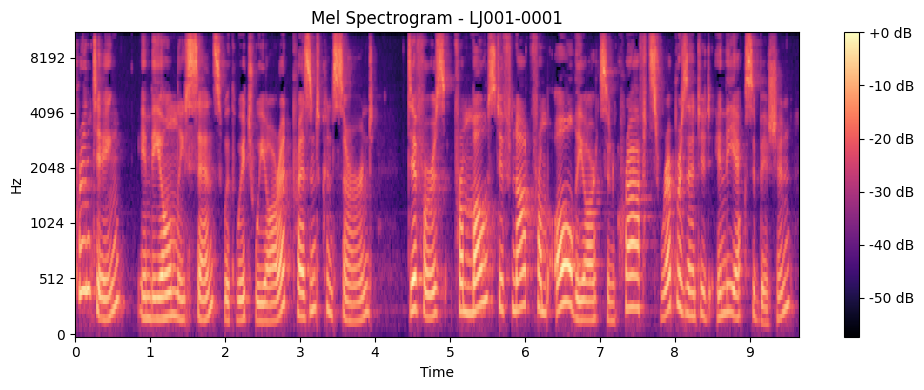

In [8]:

def plot_mel(file_id):
    mel_path = os.path.join(OUTPUT_PATH, f"{file_id}_mel.npy")
    mel = np.load(mel_path)
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=CONFIG["sample_rate"], hop_length=CONFIG["hop_length"], x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Mel Spectrogram - {file_id}")
    plt.tight_layout()
    plt.show()

# Example: plot one file
plot_mel(metadata[0]['id'])

In [9]:


text_lengths = []
durations = []
file_ids = []

for line in tqdm(lines, desc="Analyzing raw data"):
    parts = line.strip().split("|")
    if len(parts) < 2:
        continue

    file_id, raw_text = parts[0], parts[1]
    text = clean_text(raw_text)
    text_lengths.append(len(text.split()))
    file_ids.append(file_id)

    wav_path = os.path.join(WAVS_PATH, file_id + ".wav")
    try:
        y, sr = librosa.load(wav_path, sr=CONFIG["sample_rate"])
        duration = librosa.get_duration(y=y, sr=sr)
        durations.append(duration)
    except Exception as e:
        print(f"[Error] Could not load {wav_path}: {e}")
        durations.append(0)  

Analyzing raw data: 100%|██████████| 13100/13100 [00:05<00:00, 2361.36it/s]


d:\Project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


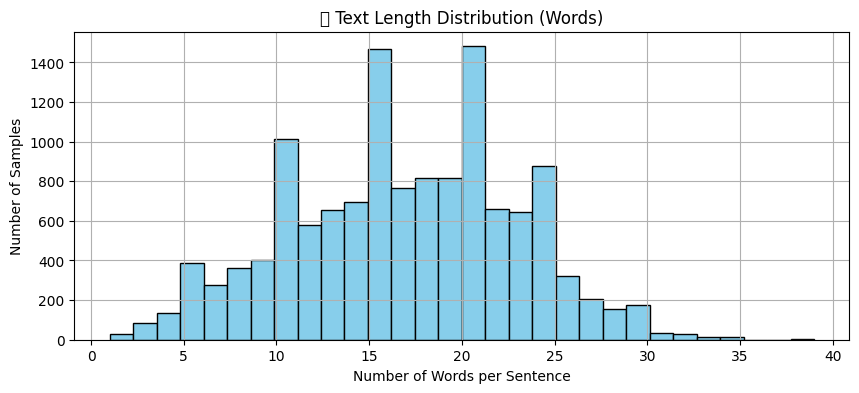

In [10]:
plt.figure(figsize=(10, 4))
plt.hist(text_lengths, bins=30, color="skyblue", edgecolor="black")
plt.title("📝 Text Length Distribution (Words)")
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

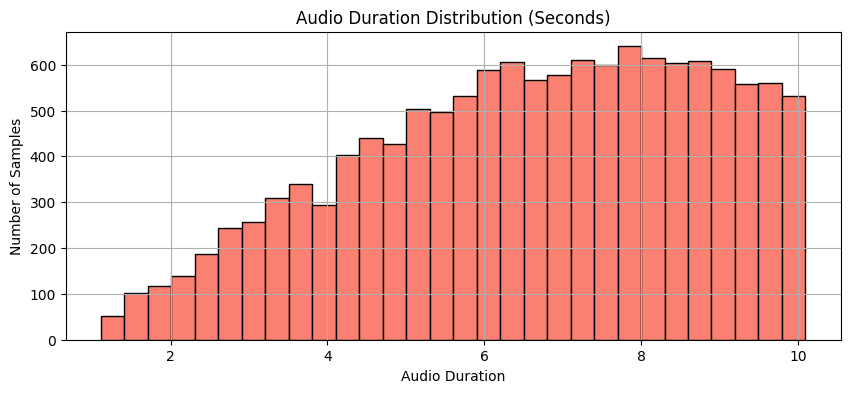

In [11]:
plt.figure(figsize=(10, 4))
plt.hist(durations, bins=30, color="salmon", edgecolor="black")
plt.title("Audio Duration Distribution (Seconds)")
plt.xlabel("Audio Duration")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

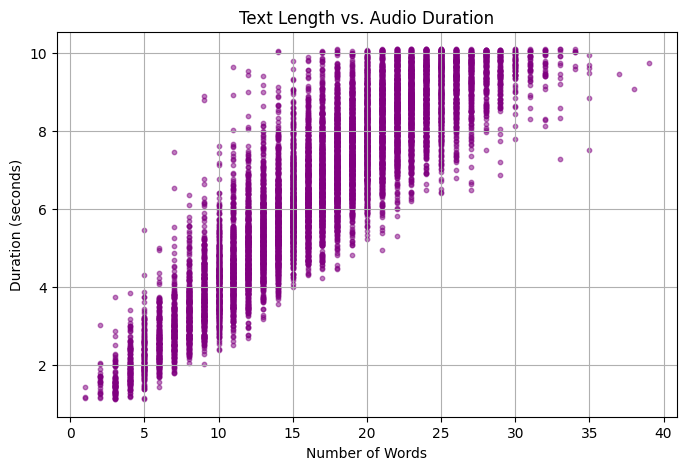

In [12]:
plt.figure(figsize=(8, 5))
plt.scatter(text_lengths, durations, alpha=0.5, s=10, c="purple")
plt.title("Text Length vs. Audio Duration")
plt.xlabel("Number of Words")
plt.ylabel("Duration (seconds)")
plt.grid(True)
plt.show()

In [13]:
# Load metadata
with open(os.path.join(OUTPUT_PATH, "metadata.json"), "r", encoding="utf-8") as f:
    metadata = json.load(f)

token_lengths = [m["token_length"] for m in metadata]
mel_lengths = [m["mel_shape"][1] for m in metadata]  # shape = [n_mels, frames]
durations = [m["duration_sec"] for m in metadata]

d:\Project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


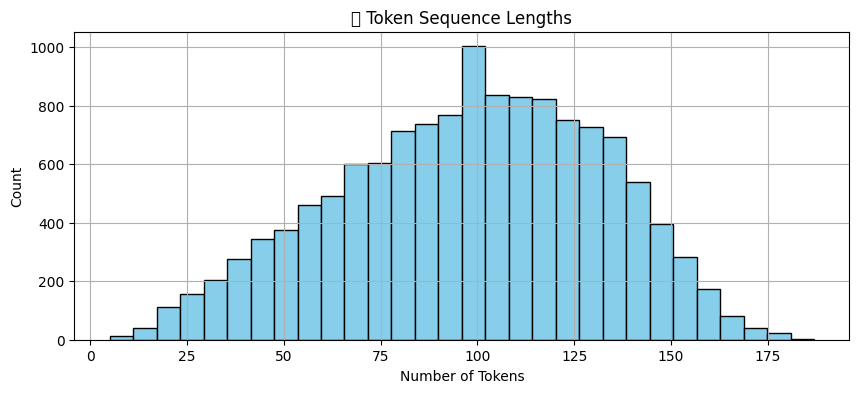

In [14]:
plt.figure(figsize=(10, 4))
plt.hist(token_lengths, bins=30, color="skyblue", edgecolor="black")
plt.title("🟦 Token Sequence Lengths")
plt.xlabel("Number of Tokens")
plt.ylabel("Count")
plt.grid(True)
plt.show()

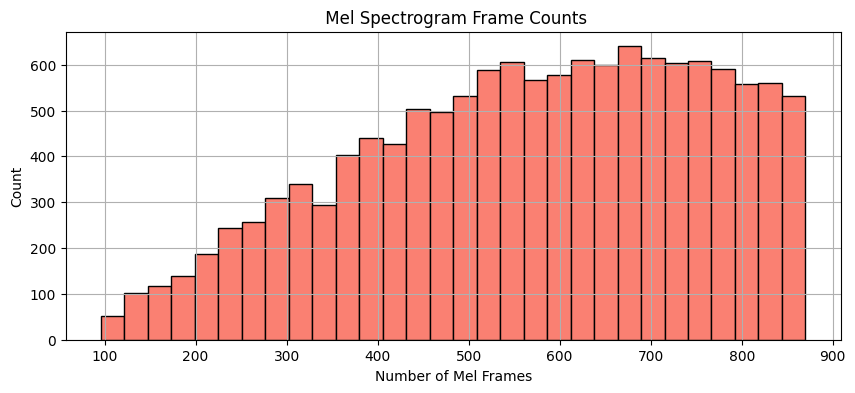

In [15]:
plt.figure(figsize=(10, 4))
plt.hist(mel_lengths, bins=30, color="salmon", edgecolor="black")
plt.title(" Mel Spectrogram Frame Counts")
plt.xlabel("Number of Mel Frames")
plt.ylabel("Count")
plt.grid(True)
plt.show()

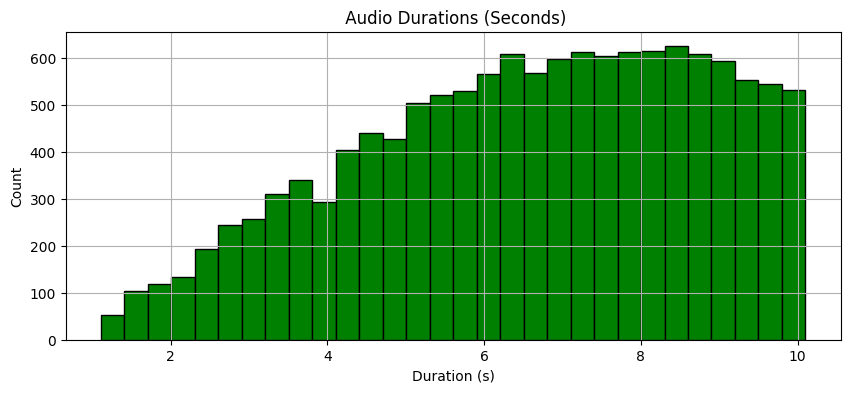

In [16]:
plt.figure(figsize=(10, 4))
plt.hist(durations, bins=30, color="green", edgecolor="black")
plt.title(" Audio Durations (Seconds)")
plt.xlabel("Duration (s)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

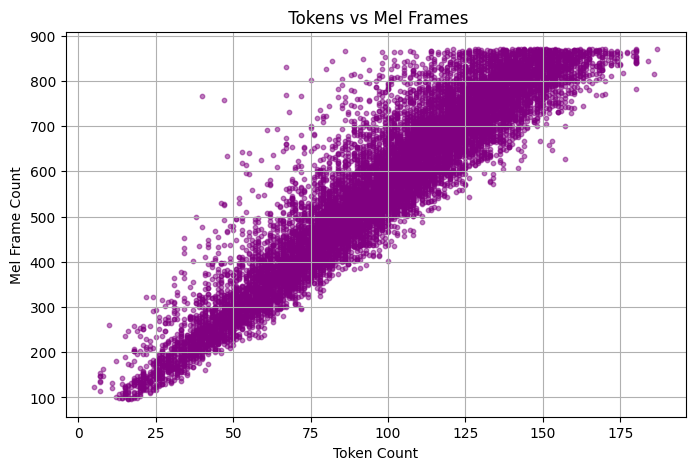

In [17]:
plt.figure(figsize=(8, 5))
plt.scatter(token_lengths, mel_lengths, alpha=0.5, s=10, c="purple")
plt.title(" Tokens vs Mel Frames")
plt.xlabel("Token Count")
plt.ylabel("Mel Frame Count")
plt.grid(True)
plt.show()

In [18]:
summary_df = pd.DataFrame({
    "token_length": token_lengths,
    "mel_frames": mel_lengths,
    "duration_sec": durations
})

print(" Summary after Preprocessing:")
display(summary_df.describe().T)

 Summary after Preprocessing:


,count,mean,std,min,25%,50%,75%,max
token_length,13100.0,97.920916,33.948291,5.00,73.00,100.00,124.00,187.0
mel_frames,13100.0,566.608550,188.237344,96.00,430.00,583.00,723.00,870.0
duration_sec,13100.0,6.573826,2.185404,1.11,4.99,6.76,8.39,10.1
